# Computational Intelligence - ResNet Presentation
---

CIFAR-10 is a dataset of 32x32 pixel images gathered for classification of 10 classes. In this notebook, a ResNet50 model was trained to classify images of this dataset.  
  
<img src="https://production-media.paperswithcode.com/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg" width="500"/>

## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
AUTOTUNE = tf.data.AUTOTUNE

## Dataset Preperation

In [ ]:
def to_categorical(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 10)
    label = tf.cast(label, tf.float32)
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    return image, label 

In [ ]:
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True, shuffle_files=True)

with tf.device('/cpu:0'):
    # preprocessing
    train_ds = train_ds.shuffle(1024)
    train_ds = train_ds.map(to_categorical, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.map(to_categorical, num_parallel_calls=AUTOTUNE)

    # batch the dataset
    train_ds = train_ds.batch(64, num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.batch(64, num_parallel_calls=AUTOTUNE)

    # cache for better performance
    train_ds = train_ds.cache()

    # repeat the training dataset
    train_ds = train_ds.repeat()

    # prefetch for beter performance
    train_ds = train_ds.prefetch(AUTOTUNE)

## Training Process

In [ ]:
# get the pretrained model
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
base_model.trainable = False

# model input
inp = tf.keras.Input(shape=(32, 32, 3), name="Input_Layer")

# upsample input
x = tf.keras.layers.UpSampling2D((2,2), name="Resize_1")(inp)
x = tf.keras.layers.UpSampling2D((2,2), name="Resize_2")(x)
x = tf.keras.layers.UpSampling2D((2,2), name="Resize_3")(x)

# preprocess input
x = tf.keras.applications.resnet.preprocess_input(x)

# make ResNet
x = base_model(x)
x = tf.keras.layers.GlobalMaxPooling2D(name="Max_Pool")(x)
x = tf.keras.layers.BatchNormalization(name="Batch_Norm")(x)

# make classifier
x = tf.keras.layers.Dropout(0.3, name="Dropout")(x)
x = tf.keras.layers.Dense(10, activation='softmax', name="Classifier")(x)

# finalize model
model = tf.keras.models.Model(inputs=inp, outputs=x, name="ResNet50")
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 Resize_1 (UpSampling2D)     (None, 64, 64, 3)         0         
                                                                 
 Resize_2 (UpSampling2D)     (None, 128, 128, 3)       0         
                                                                 
 Resize_3 (UpSampling2D)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_4   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                       

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# fit the model
hist = model.fit(
    train_ds,
    epochs=6,
    steps_per_epoch=50000//64,
    validation_data=test_ds,
)

Epoch 1/6
781/781 [==============================] - 424s 539ms/step - loss: 1.0260 - acc: 0.6572 - val_loss: 0.6602 - val_acc: 0.7749
Epoch 2/6
781/781 [==============================] - 421s 539ms/step - loss: 0.7188 - acc: 0.7553 - val_loss: 0.5911 - val_acc: 0.7989
Epoch 3/6
781/781 [==============================] - 421s 539ms/step - loss: 0.6476 - acc: 0.7798 - val_loss: 0.5606 - val_acc: 0.8093
Epoch 4/6
781/781 [==============================] - 421s 539ms/step - loss: 0.6069 - acc: 0.7929 - val_loss: 0.5456 - val_acc: 0.8143
Epoch 5/6
781/781 [==============================] - 421s 539ms/step - loss: 0.5823 - acc: 0.7996 - val_loss: 0.5356 - val_acc: 0.8184
Epoch 6/6
781/781 [==============================] - 421s 539ms/step - loss: 0.5671 - acc: 0.8033 - val_loss: 0.5282 - val_acc: 0.8197


## Evaluation

In [ ]:
# calculate confusion matrix
y_pred = model.predict(test_ds)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)
true_categories = tf.argmax(true_categories, axis=1)
matrix = confusion_matrix(predicted_categories, true_categories, normalize='true')
conf_mat = ConfusionMatrixDisplay(matrix)

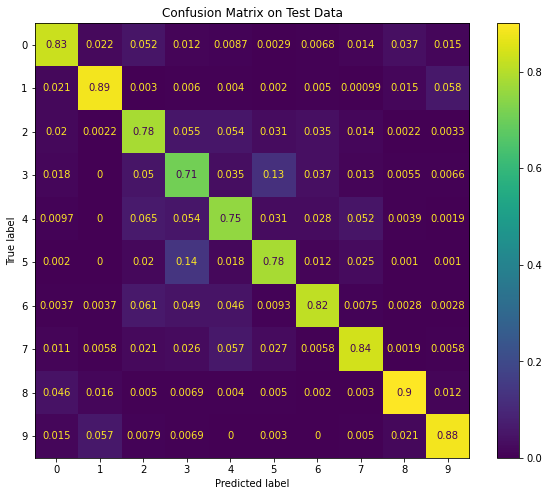

In [ ]:
# plot confusion matrix
fig, ax = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(10)
ax = conf_mat.plot(ax=ax)
plt.title("Confusion Matrix on Test Data")
plt.show()